Hyperparameter optimisation (or tuning) is the process of choosing a set of optimal parameters for a machine learning algorithm.<br>
The most typical hyperparameters in deep learning include learning rate, number of hidden layers in a deep neural network, batch size, dropout…<br>
But also, in NLP with should bother with parameters like type of embedding, embedding dimension, number of RNN layers…<br>
Hyperparameter optimisation, in NLP, require better method than hand-picking, with respect to exponentially growing parameters space.<br>
Currently, the dominant algorithms of searching the parameter space for complex models are Bayesian Optimization and Tree-structured Parzen Estimator(TPE).<br>
Due to the fact that much more time and resources are required, as it basically performs a lot of training, it is recommended to run this on hardware accelerated by the GPU.

In [2]:
!pip3 install flair

     |████████████████████████████████| 143kB 8.8MB/s eta 0:00:01
  Created wheel for sqlitedict: filename=sqlitedict-1.6.0-cp36-none-any.whl size=14689 sha256=fa38cbab40f3a0f5b8b97018b46b4fd61aa30b10681362a3c0f884ecb486087e
  Stored in directory: /tmp/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
  Created wheel for segtok: filename=segtok-1.5.7-cp36-none-any.whl size=23257 sha256=af8501d27445c6064385fcb23079e40b3531005e76c7615290fc748a9bda7dce
  Stored in directory: /tmp/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
Successfully built sqlitedict segtok


In [1]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

import torch
torch.cuda.is_available()

True

# Dataset

In [3]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

In [4]:
FILE_PATH = "../input/spam.csv"
DATASET_FOLDER_PATH = "splitted_data/spam"
MODEL_FOLDER_PATH = "model"
column_name = {
    "text": "v2",
    "label": "v1"
}

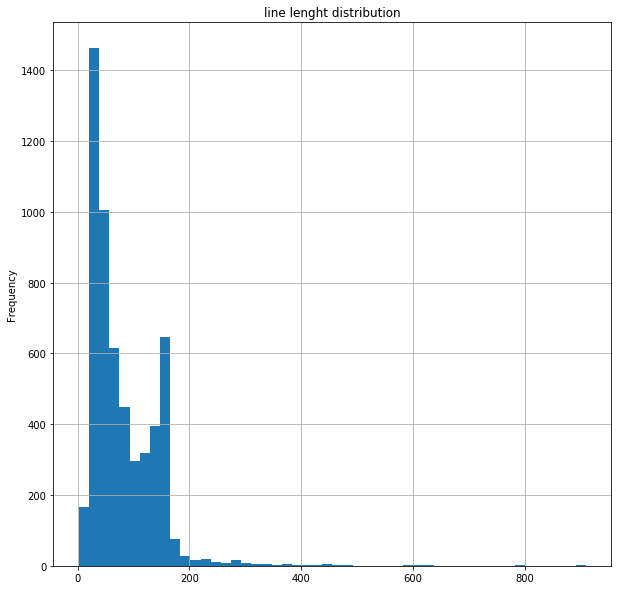

In [5]:
data_df = pd.read_csv(FILE_PATH, encoding="latin").sample(frac=1)
data_df[column_name["label"]] = '__label__' + data_df[column_name["label"]].astype(str)

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

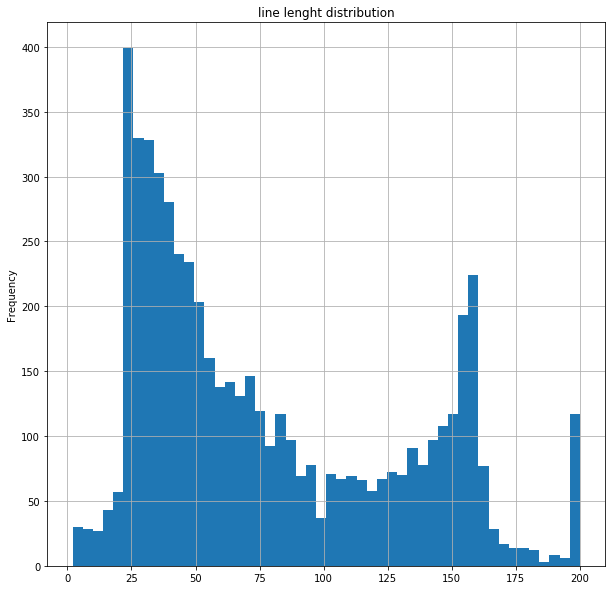

In [6]:
import re
from string import digits, punctuation

def clear_text(text, is_all_lower=True):
    punct = re.sub(r'[\.,!?&\-]', '', punctuation)
    punctuation_table = str.maketrans({key: "#" for key in punct})
    for char in ["\"", "\'"]:
        del punctuation_table[ord(char)]
    
    review_cleaned = text.apply(lambda x: re.sub(r'[^\x00-\x7F]', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r'[0-9]', '9', x))
    review_cleaned = review_cleaned.apply(lambda x: x.translate(punctuation_table))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' +', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' (?=[\.,!?&\-])','', x))
    
    if is_all_lower:
        review_cleaned = review_cleaned.str.lower()
        
    return review_cleaned

data_df[column_name["text"]] = data_df[column_name["text"]]
data_df[column_name["text"]] = data_df[column_name["text"]].apply(lambda x: x[:200])

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

In [7]:
if not os.path.exists(DATASET_FOLDER_PATH):
    os.makedirs(DATASET_FOLDER_PATH)
data_df.iloc[0: int(len(data_df)*0.8)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'train.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.8): int(len(data_df)*0.9)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'dev.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.9): ].to_csv(os.path.join(DATASET_FOLDER_PATH, 'test.csv'), sep='\t', index = False, header = False);

In [8]:
corpus: Corpus = ClassificationCorpus(DATASET_FOLDER_PATH)

2019-08-10 13:03:23,622 Reading data from splitted_data/spam
2019-08-10 13:03:23,623 Train: splitted_data/spam/train.csv
2019-08-10 13:03:23,625 Dev: splitted_data/spam/dev.csv
2019-08-10 13:03:23,626 Test: splitted_data/spam/test.csv


# Train a Model

In [9]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric

In [ ]:
if not os.path.exists(MODEL_FOLDER_PATH):
    os.makedirs(MODEL_FOLDER_PATH)

params_train = {
    "word_emb": 'glove',
    "flair_emb_forward": 'news-forward-fast',
    "flair_emb_backward": 'news-backward-fast',
    "hidden_size": 256,
    "reproject_words_dimension": 128,
    "max_epoch": 10,
    "evaluation_metric": EvaluationMetric.MICRO_ACCURACY
}

In [ ]:
word_embeddings = [WordEmbeddings(params_train["word_emb"]), FlairEmbeddings(params_train["flair_emb_forward"]),
                   FlairEmbeddings(params_train["flair_emb_backward"])]

document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=params_train["hidden_size"],
                                            reproject_words=True, reproject_words_dimension=params_train["reproject_words_dimension"])

classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)

trainer = ModelTrainer(classifier, corpus)


trainer.train(MODEL_FOLDER_PATH, max_epochs=params_train["max_epoch"], evaluation_metric=params_train["evaluation_metric"])

# Learning rate

In [ ]:
learning_rate_tsv = trainer.find_learning_rate(MODEL_FOLDER_PATH, 'learning_rate.tsv')

In [ ]:
plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

<img src="model/learning_rate.png" height=1000, width=1000>

# Hyperparameters Optimization

#### list of all available hyperparameters to tune
https://github.com/zalandoresearch/flair/blob/master/flair/hyperparameter/parameter.py

In [10]:
from hyperopt import hp
from flair.hyperparameter.param_selection import SearchSpace, Parameter, TextClassifierParamSelector, OptimizationValue
from flair.embeddings import WordEmbeddings, FlairEmbeddings
from flair.data_fetcher import NLPTaskDataFetcher
from pathlib import Path

In [14]:
# define your search space
search_space = SearchSpace()
search_space.add(Parameter.EMBEDDINGS, hp.choice, options=[
    [ WordEmbeddings('en') ], 
    [ FlairEmbeddings('news-forward'), FlairEmbeddings('news-backward') ]
])
search_space.add(Parameter.HIDDEN_SIZE, hp.choice, options=[32, 64, 128, 256])
search_space.add(Parameter.RNN_LAYERS, hp.choice, options=[1, 2])
search_space.add(Parameter.DROPOUT, hp.uniform, low=0.1, high=0.5)
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[0.05, 0.1, 0.15, 0.2])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[8, 16, 32])

In [15]:
param_selector = TextClassifierParamSelector(
    corpus=corpus, 
    multi_label=False, 
    base_path=MODEL_FOLDER_PATH, 
    document_embedding_type='lstm',
    max_epochs=10, 
    training_runs=3,
    optimization_value=OptimizationValue.DEV_SCORE
)

2019-08-10 16:02:17,098 {'ham', 'spam'}


In [16]:
param_selector.optimize(search_space, max_evals=10)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]2019-08-10 16:02:21,526 ----------------------------------------------------------------------------------------------------
2019-08-10 16:02:21,530 Evaluation run: 1
2019-08-10 16:02:21,532 Evaluating parameter combination:
2019-08-10 16:02:21,535 	dropout: 0.10426696339723916
2019-08-10 16:02:21,537 	embeddings: /tmp/.flair/embeddings/news-forward-0.4.1.pt,/tmp/.flair/embeddings/news-backward-0.4.1.pt
2019-08-10 16:02:21,539 	hidden_size: 128
2019-08-10 16:02:21,541 	learning_rate: 0.2
2019-08-10 16:02:21,546 	mini_batch_size: 16
2019-08-10 16:02:21,548 	rnn_layers: 2
2019-08-10 16:02:21,550 ----------------------------------------------------------------------------------------------------
2019-08-10 16:02:24,255 ----------------------------------------------------------------------------------------------------
2019-08-10 16:02:24,259 Training run: 1
2019-08-10 16:02:24,565 ---------------------------------------------------------

The parameter settings and the evaluation scores will be written to $\textbf{param_selection.txt}$ in the result directory. 